In [1]:
### Load PPS model
%run ./HC_model.ipynb

In [2]:
# Tactile area
def myLIt(z,Lt): # z is a matrix of MtxNt dimensions
    LI = np.zeros(Mt*Nt)
    z = np.reshape(z,(1,Mt*Nt))
    for i in range(Mt*Nt):
            LI[i] = np.sum(np.multiply(Lt[i,:],z[0,:])) 
    LI = np.reshape(LI,(Mt,Nt))
    return LI

# Auditory area
def myLIa(z,La): # z is a matrix of MaxNa dimensions
    LI = np.zeros(Ma*Na)
    z = np.reshape(z,(1,Ma*Na))
    for i in range(Ma*Na):
            LI[i] = np.sum(np.multiply(La[i,:],z[0,:])) 
    LI = np.reshape(LI,(Ma,Na))
    return LI

# Experiment
def myexperimentrun(a_distances,time,b,pr,Lex,Lin,Sex,Sin):
    Lt,La = Lw(Lex,Lin,Sex,Sin,Lex,Lin,Sex*20,Sin*20)
    
    dt = 0.4
    timesteps = int(time/dt)
    ndist = len(a_distances)
    
    RTs = np.zeros(ndist)
    ZTs = np.zeros((Mt,Nt,ndist))
    ZAs = np.zeros((Ma,Na,ndist))
    
    ti = PHIt(0) 
    #PrBa = prun(Ba,pr)
    #PrWa = prun(Wa,pr*2.6)
    PrWa = prun(Wa,pr)
    dtau = dt/tau
    
    qt = np.zeros((Mt,Nt,timesteps+1,ndist))
    ut = np.zeros((Mt,Nt,timesteps+1,ndist))
    zt = np.zeros((Mt,Nt,timesteps+1,ndist))
    pt = np.zeros((Mt,Nt,timesteps+1,ndist))

    qa = np.zeros((Ma,Na,timesteps+1,ndist))
    ua = np.zeros((Ma,Na,timesteps+1,ndist))
    za = np.zeros((Ma,Na,timesteps+1,ndist))
    pa = np.zeros((Ma,Na,timesteps+1,ndist))

    qm = np.zeros((timesteps+1,ndist))
    um = np.zeros((timesteps+1,ndist))
    zm = np.zeros((timesteps+1,ndist))
    pm = np.zeros((timesteps+1,ndist))
    
    rt = np.zeros((timesteps+1,ndist))
    
    for d in range(ndist):
        xa_0 = a_distances[d] # How far the sound is presented.     
        ai = PHIa(0,xa_0) # Generates an auditory input

        for i in range(timesteps):    
            # Tactile activity
            ut[:,:,i+1,d] = ti+myLIt(zt[:,:,i,d],Lt)+bt(zm[i,d])
            qt[:,:,i+1,d] = qt[:,:,i,d] + dtau*(-qt[:,:,i,d]+ut[:,:,i,d])
            pt[:,:,i+1,d] = psit(qt[:,:,i,d],b)
            zt[:,:,i+1,d] = pt[:,:,i,d]*np.heaviside(pt[:,:,i,d],0)

            # Auditory activity
            ua[:,:,i+1,d] = ai+myLIa(za[:,:,i,d],La)+ba(zm[i,d],Ba) 
            qa[:,:,i+1,d] = qa[:,:,i,d] + dtau*(-qa[:,:,i,d]+ua[:,:,i,d])
            pa[:,:,i+1,d] = psia(qa[:,:,i,d],b)
            za[:,:,i+1,d] = pa[:,:,i,d]*np.heaviside(pa[:,:,i,d],0)

            # Multisensory activity
            um[i+1,d] = np.sum(np.multiply(Wt,zt[:,:,i,d])) + np.sum(np.multiply(PrWa,za[:,:,i,d]))
            qm[i+1,d] = qm[i,d] + dtau*(-qm[i,d]+um[i,d])
            pm[i+1,d] = psim(qm[i,d])
            zm[i+1,d] = pm[i,d]*np.heaviside(pm[i,d],0)
            
            # Response
            rt[i+1,d] = np.any(zt[:,:,i,d]>(0.9*ft_max))
            
        RTs[d] = np.argmax(rt[:,d])*dt
        ZMs = zm        
        ZTs[:,:,d] = zt[:,:,timesteps,d]
        ZAs[:,:,d] = za[:,:,timesteps,d]   
    return RTs,ZMs,ZTs,ZAs

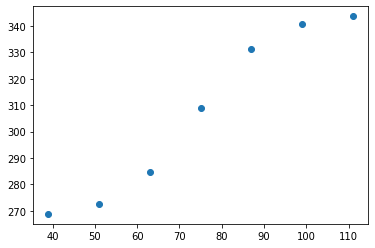

In [3]:
### Audio-tactile experiment simulation setup 

## Calculate distance in cms. Speaker is positioned at 100cm from the hand. 
s_distances = np.asarray([2700,2200,1500,800,300])/1000
ts = np.linspace(s_distances[0],s_distances[-1],7)
v = 30 #cm/s 
a_distances = (120 - ts*v) # distance points in cm (network coordinates)

## Simulation setup
simtime = 100 #ms 

## Synapses setup
Lt,La = Lw(0.15,0.05,1,4,0.15,0.05,20,80)
Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5) 
bi = 0
pr = 0

# Experimental Data
ymin = 267.49264705882354
ymax = 344.6744295011452
cp = 120-1.542*v
slope = 1/0.11724137931
SPQ_RTs = RTsig(a_distances,cp,slope)
plt.scatter(a_distances,SPQ_RTs)

In [4]:
def spqmodelrun(theta):
    spqRTs,ZMs,ZTs,ZAs = myexperimentrun(a_distances,simtime,bi,theta[0],theta[1],0.05,1,4)
    xf = spqRTs
    yf = SPQ_RTs
    
    m = 2.731234267507431
    bias = 137.62949745342593
    
    cost = np.sum(np.square(np.divide(yf-(m*xf+bias),yf)))
    
    return cost*100000

bounds=[(0,6.5),(0,3)]
res = differential_evolution(spqmodelrun,bounds,disp=True)

differential_evolution step 1: f(x)= 712.196
differential_evolution step 2: f(x)= 712.196
differential_evolution step 3: f(x)= 692.919
differential_evolution step 4: f(x)= 680.63
differential_evolution step 5: f(x)= 679.867
differential_evolution step 6: f(x)= 661.42
differential_evolution step 7: f(x)= 661.42
differential_evolution step 8: f(x)= 661.42
differential_evolution step 9: f(x)= 661.42
differential_evolution step 10: f(x)= 661.42
differential_evolution step 11: f(x)= 661.42
differential_evolution step 12: f(x)= 661.42
differential_evolution step 13: f(x)= 661.42
differential_evolution step 14: f(x)= 661.42


In [5]:
print(res)

     fun: 661.4200333768836
 message: 'Optimization terminated successfully.'
    nfev: 453
     nit: 14
 success: True
       x: array([0.96711394, 1.0004849 ])


In [6]:
spqRTs,ZMs,ZTs,ZAs = myexperimentrun(a_distances,simtime,0,0.96711394, 1.0004849,0.05,1,4)

2.731234267507431 137.62949745342593


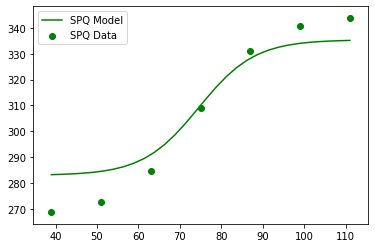

In [8]:
xf = spqRTs
yf = SPQ_RTs    
m = 2.731234267507431
bias = 137.62949745342593

ymin,ymax = np.min(m*xf+bias),np.max(m*xf+bias) 
dc,h = sigfit(a_distances,m*xf+bias)
a_distances_exp = np.linspace(a_distances[0],a_distances[-1],30)
yf_exp = RTsig(a_distances_exp,dc,h)

plt.figure(1)
plt.plot(a_distances_exp,yf_exp,label = 'SPQ Model',color='g')
plt.scatter(a_distances,yf,label = 'SPQ Data',color='g')
plt.legend()

print(m,bias)

In [15]:
spqres = np.asarray([yf_exp,yf])
np.save('spq_lex_pr.npy', spqres)

In [12]:
from sklearn import metrics
print(metrics.mean_squared_error(yf,m*xf+bias,squared=False))

1.2834244390816407


In [14]:
def adjrmse(model,data,k):
    sse = np.sum(np.square(data-model))
    n = len(model)
    return np.sqrt(sse/(n-k))

spq_error = adjrmse(m*xf+bias,spqres[1],4)
print(spq_error)

1.960463213615953


In [20]:
myWa = prun(Wa,0.57683018)
100*(1-np.sum(myWa)/np.sum(Wa))

4.570394564633551